In [1]:
%pip install --quiet jupysql ipywidgets ipympl duckdb duckdb-engine pandas matplotlib jupyterlab

Note: you may need to restart the kernel to use updated packages.


In [2]:
import duckdb
import pandas as pd
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
%load_ext sql
%matplotlib widget

In [3]:
%config SqlMagic.autopandas = True
%config SqlMagic.displaycon = False

In [4]:
%sql duckdb:///./381720.duckdb

Connecting to 'duckdb:///./381720.duckdb'

In [5]:
%sqlcmd tables

Name
Gateway
Site
Node
Message
Trace
Radio
Power_Consumption
Downlink_Event_Error_Message
Join_Message
Content_Message


In [6]:
%sql select * from Trace

,trace_id,node_id,timestamp,message
0,1,70B3D57ED005E88A,2023-10-19 11:24:55.100664, ztimer_init(): initializing rtt\n
1,2,70B3D57ED005E88A,2023-10-19 11:24:55.105563,ztimer_init(): ZTIMER_RTT setting block_pm_mod...
2,3,70B3D57ED005E88A,2023-10-19 11:24:55.110605,ztimer_init(): ZTIMER_MSEC convert_frac from 3...
3,4,70B3D57ED005E88A,2023-10-19 11:24:55.115489,ztimer_init(): ZTIMER_SEC convert_frac from 32...
4,5,70B3D57ED005E88A,2023-10-19 11:24:55.119485,[auto_init_saul] initializing GPIO #0\n
...,...,...,...,...
87,88,70B3D57ED005E88A,2023-10-19 11:24:55.547604,sensor collect took 28 ms\n
88,89,70B3D57ED005E88A,2023-10-19 11:24:55.549598,Execution took 26 ms\n
89,90,70B3D57ED005E88A,2023-10-19 11:24:55.551625,Send took 18 ms\n
90,91,70B3D57ED005E88A,2023-10-19 11:24:55.553640,Iteration took 278 ms\n


In [7]:
%sql nodes =<< select distinct * from Node

,node_deveui,node_appeui,node_appkey,board_id,radio_chipset,node_site,profile,riot_board
0,70B3D57ED005E88A,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1


In [8]:

timestamps=%sql select timestamp from Power_Consumption 
#timestamps = timestamps["timestamp"].map(lambda x: x.isoformat())
%sql SUMMARIZE Power_Consumption

,column_name,column_type,min,max,approx_unique,avg,std,q25,q50,q75,count,null_percentage
0,power_consumption_id,INTEGER,1,70294,69764,35147.5,20292.27424826177,17707,35216,52722,70294,0.0%
1,node_id,VARCHAR,70B3D57ED005E88A,70B3D57ED005E88A,1,None,None,None,None,None,70294,0.0%
2,timestamp,TIMESTAMP,2023-10-19 11:24:38.159993,2023-10-19 11:29:43.814599,71531,None,None,None,None,None,70294,0.0%
3,current,FLOAT,0.0,0.123388,562,0.057829312980749954,0.005719837706496366,0.056820070574990576,0.057295095051599375,0.057801378575282,70294,0.0%
4,voltage,FLOAT,1.58125,4.925,134,4.854697234478567,0.12278296765288435,4.858749866485596,4.860000133514404,4.860000133514404,70294,0.0%
5,power,FLOAT,0.0,0.600704,188,0.28101623860803454,0.02776811687948848,0.2760356380380388,0.2783749997615814,0.2808170020580292,70294,0.0%


In [9]:
%sql select node_id,count(*),min(timestamp),max(timestamp) from Power_Consumption group by node_id

,node_id,count_star(),"min(""timestamp"")","max(""timestamp"")"
0,70B3D57ED005E88A,70294,2023-10-19 11:24:38.159993,2023-10-19 11:29:43.814599


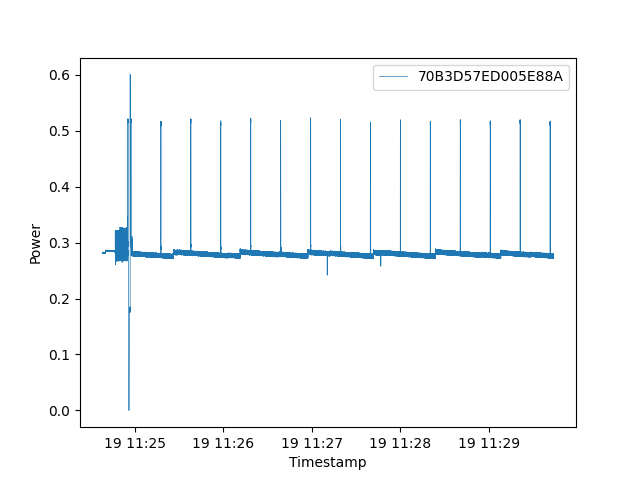

In [10]:
deveui = "70B3D57ED005EA56"

power= %sql select timestamp,power,current,voltage,node_id from Power_Consumption
power = power.set_index("timestamp")
#plot power with timestamps as x axis. timestamps need to show milliseconds
groups = power.groupby("node_id")
plt.figure()
for node_id, group in groups:
    plt.plot(group.index, group["power"], label=node_id, linewidth=0.5)

plt.xlabel("Timestamp")
plt.ylabel("Power")
plt.legend()
plt.show()

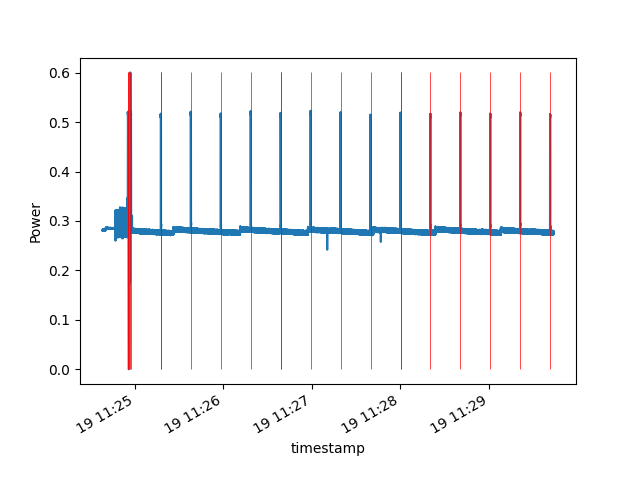

In [11]:
plt.figure()
plt.ylabel("Power")
# single node
power_single = power[(power["node_id"] =="70B3D57ED005E88A")]
power_single["power"].plot()
power_diff = power_single[(power_single["node_id"] =="70B3D57ED005E88A")]["power"].diff()

filtered_power_diff = power_diff[power_diff < -.1]
plt.vlines(filtered_power_diff.index, ymin=power_single["power"].min(), ymax=power_single["power"].max(), color="red", linewidth=0.5)
plt.show()

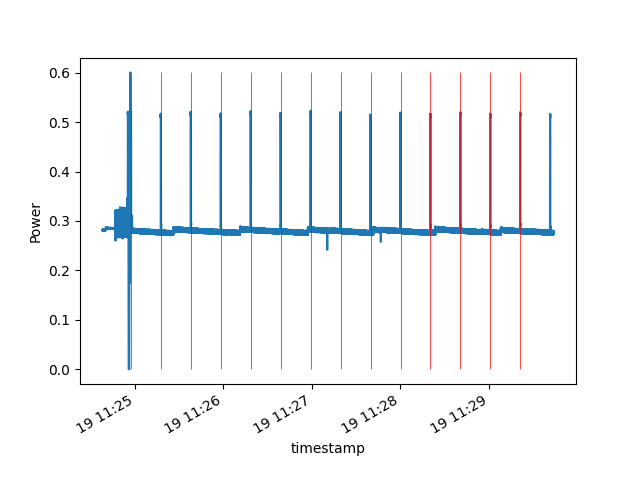

In [33]:
#remove values where difference is not greater or less than 20 seconds
diff = filtered_power_diff.index.to_series().diff(-1).abs()
plt.figure()
plt.ylabel("Power")
# single node

power_single["power"].plot()

plt.vlines(filtered_power_diff.index[(diff < pd.Timedelta(seconds=21))  & (diff > pd.Timedelta(seconds=19))], ymin=power_single["power"].min(), ymax=power_single["power"].max(), color="red", linewidth=0.5)
plt.show()

In [34]:
#traces from single node
%sql select * from Trace where node_id LIKE '70B3D57ED005E88A'

,trace_id,node_id,timestamp,message
0,1,70B3D57ED005E88A,2023-10-19 11:24:55.100664, ztimer_init(): initializing rtt\n
1,2,70B3D57ED005E88A,2023-10-19 11:24:55.105563,ztimer_init(): ZTIMER_RTT setting block_pm_mod...
2,3,70B3D57ED005E88A,2023-10-19 11:24:55.110605,ztimer_init(): ZTIMER_MSEC convert_frac from 3...
3,4,70B3D57ED005E88A,2023-10-19 11:24:55.115489,ztimer_init(): ZTIMER_SEC convert_frac from 32...
4,5,70B3D57ED005E88A,2023-10-19 11:24:55.119485,[auto_init_saul] initializing GPIO #0\n
...,...,...,...,...
87,88,70B3D57ED005E88A,2023-10-19 11:24:55.547604,sensor collect took 28 ms\n
88,89,70B3D57ED005E88A,2023-10-19 11:24:55.549598,Execution took 26 ms\n
89,90,70B3D57ED005E88A,2023-10-19 11:24:55.551625,Send took 18 ms\n
90,91,70B3D57ED005E88A,2023-10-19 11:24:55.553640,Iteration took 278 ms\n


In [14]:
# lower=widgets.SelectionSlider(options=timestamps, value=timestamps.min())
# upper=widgets.SelectionSlider(options=timestamps, value=timestamps.max())
# %sql --save hej --interact deveuis --interact lower --interact upper SELECT * from Power_Consumption where node_id LIKE '{{deveuis}}' AND timestamp BETWEEN '{{lower}}' AND '{{upper}}'